### 用Efficient DD的思路，不使用辅助比特，使用多控制比特门，在LimTDD上实现了态制备 - 对应Alg. 1-增加了计算表结果复用

In [6]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing,get_index_order
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate,MCXGate
from qiskit.qasm3 import dumps,loads

to_test = False

In [7]:
def simulate(cir,ini=False,n=0):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
    # n = get_real_qubit_num(cir)
    if n!=0:
        add_inputs(tn,[0]*n,n)

    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for k1 in range(n):
            if not 'x'+str(k1) in var:
                var.append('x'+str(k1))
            for k in range(5*len(all_indexs)):
                s ='x'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)               
            if not 'y'+str(k1) in var:
                var.append('y'+str(k1))
        var.reverse()
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)
    tdd=tn.cont()
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd,tdd1)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    # temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    temp_tdd = Slicing2(tdd,tdd.node.key,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

def get_gate_data(cir):
    data = {}
    for d in cir.data:
        a = len(d.qubits)
        if a in data:
            data[a]+=1
        else:
            data[a]=1
    return data

def get_gate_data2(cir):
    data = 0
    for d in cir.data:
        data += len(d.qubits)
    return data

In [8]:
def get_meas_prob(node):
    if node.meas_prob!=[]:
        return
    if node.key==-1:
        return
    if node.key==0:
        node.meas_prob = [abs(node.out_weight[0])**2,abs(node.out_weight[1])**2]
        return
    if node.successor[0].meas_prob==[]:
        get_meas_prob(node.successor[0])
    if node.successor[1].meas_prob==[]:
        get_meas_prob(node.successor[1])
    node.meas_prob.append(abs(node.out_weight[0])**2*sum(node.successor[0].meas_prob))
    node.meas_prob.append(abs(node.out_weight[1])**2*sum(node.successor[1].meas_prob))
    node.successor[0].ref+=1
    # if node.successor[1]!=node.successor[0]:
    node.successor[1].ref+=1

    return

In [9]:
# def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    
#     if add_qubits_num==0:
#         add_qubits_num = len(cond)

#     circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

#     for g, qargs, cargs in cir.data:
#         cg = g.control(len(cond))
#         new_qubits = [k for k in cond]
#         for k in qargs:
#             new_qubits.append(k._index)
#         for k in cond:
#             if cond[k]==0:
#                 circ.x(k)
#         circ.append(cg,new_qubits)
#         for k in cond:
#             if cond[k]==0:
#                 circ.x(k) 

#     return circ

computed_a_c = {}
def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    global computed_a_c
    if add_qubits_num==0:
        add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        if len(g.params)>0:
            kk = (g.name,g.num_qubits,str(g.params[0]),len(cond))
        else:
            kk = (g.name,g.num_qubits,len(cond))
        if kk in computed_a_c:
            cg = computed_a_c[kk]
        else:
            cg = g.control(len(cond))
            computed_a_c[kk] = cg

        new_qubits = [k for k in cond]
        for k in qargs:
            new_qubits.append(k._index)
        for k in cond:
            if cond[k]==0:
                circ.x(k)
        circ.append(cg,new_qubits)
        for k in cond:
            if cond[k]==0:
                circ.x(k)        
    return circ


def state_pre_Org(tdd,anc_num=0):

    if tdd.node.key==-1:
        return QuantumCircuit(0),1
    print(tdd.node.key,tdd.weight)
    n = tdd.node.key+1
    cir = QuantumCircuit(n)

    the_map=tdd.map
    print(the_map,'a')
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.x(q)        
        if the_map.rotate>0:
            cir.p(np.pi/4*(8-the_map.rotate),q) 
        the_map=the_map.father

    u = tdd.node
    the_map = u.out_maps[1]
    print(the_map,'b')
    while the_map.level>-1:
        q1 = u.key
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.cx(q1,q)
        if the_map.rotate>0:
            cir.cp(np.pi/4*(8-the_map.rotate),q1,q)
        the_map=the_map.father

    bran_tdd = TDD(u.successor[0])
    print(bran_tdd.node.key,'d')
    n2 = bran_tdd.node.key+1
    bran_tdd.index_set = []
    bran_tdd.key_2_index ={-1:-1}
    bran_tdd.key_width = {}
    for k in range(n2):
        bran_tdd.index_set.append(Index('y'+str(k),0))
        bran_tdd.key_2_index[k] = 'y'+str(k)
        bran_tdd.key_width[k] = 2
    bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index}
    print('g1')
    cir_end_t0, hold_prob0 = state_pre_Org(bran_tdd)
    print('g2')
    if tdd.node.successor[0]!=tdd.node.successor[1]:
        bran_tdd = TDD(u.successor[1])
        print(bran_tdd.node.key,'e')
        n2 = bran_tdd.node.key+1
        bran_tdd.index_set = []
        bran_tdd.key_2_index ={-1:-1}
        bran_tdd.key_width = {}
        for k in range(n2):
            bran_tdd.index_set.append(Index('y'+str(k),0))
            bran_tdd.key_2_index[k] = 'y'+str(k)
            bran_tdd.key_width[k] = 2
        bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index} 
        print('g3')
        cir_end_t1, hold_prob1 = state_pre_Org(bran_tdd)
        print('g4')
        print(len(cir_end_t0.data),len(cir_end_t1.data))
        t_start = time.time()
        cir_end_t0 = get_controlled_circuit2(cir_end_t0,{u.key:0},1)
        cir_end_t1 = get_controlled_circuit2(cir_end_t1,{u.key:1},1)
        print(time.time()-t_start)
        cir=cir&cir_end_t0
        cir=cir&cir_end_t1
    else:
        t_start = time.time()
        for g, qargs, cargs in cir_end_t0.data:
            new_qubits = []
            for k in qargs:
                new_qubits.append(k._index)
            cir.append(g,new_qubits)
        hold_prob1 = hold_prob0
        
    w0 = u.out_weight[0]*hold_prob0
    w1 = u.out_weight[1]*hold_prob1
    a=w1/w0
    M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
    print(M,'c',tdd.node.key)
    u3 = UnitaryGate(M)
    cir.append(u3,[u.key])
    hold_prob = w0*np.sqrt(1+abs(a)**2)
    return cir, hold_prob




def state_pre2(u,key_2_index,computed  = {}):

    if u.key==-1:
        return QuantumCircuit(0),1

    if u in computed:
        return computed[u][0],computed[u][1]
    
    n = u.key+1
    cir = QuantumCircuit(n)

    the_map = u.out_maps[1]
    while the_map.level>-1:
        q1 = u.key
        idx = the_map.level
        q = int(key_2_index[idx][1:])
        if the_map.x==1:
            cir.cx(q1,q)
        if the_map.rotate>0:
            cir.cp(np.pi/4*(8-the_map.rotate),q1,q)
        the_map=the_map.father


    cir_end_t0, hold_prob0 = state_pre2(u.successor[0],key_2_index,computed)
    if u.successor[0]!=u.successor[1]:
        cir_end_t1, hold_prob1 = state_pre2(u.successor[1],key_2_index,computed)
        cir_end_t0 = get_controlled_circuit2(cir_end_t0,{u.key:0},1)
        cir_end_t1 = get_controlled_circuit2(cir_end_t1,{u.key:1},1)
        cir=cir&cir_end_t0
        cir=cir&cir_end_t1
    else:
        for g, qargs, cargs in cir_end_t0.data:
            new_qubits = []
            for k in qargs:
                new_qubits.append(k._index)
            cir.append(g,new_qubits)
        hold_prob1 = hold_prob0
        
    w0 = u.out_weight[0]*hold_prob0
    w1 = u.out_weight[1]*hold_prob1
    a=w1/w0
    M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
    u3 = UnitaryGate(M)
    cir.append(u3,[u.key])
    hold_prob = w0*np.sqrt(1+abs(a)**2)
    computed[u] = (cir,hold_prob)
    return cir, hold_prob


def state_pre(tdd,anc_num=0):
    global computed_a_c
    computed_a_c = {}
    if tdd.node.key==-1:
        return QuantumCircuit(0),1

    n = tdd.node.key+1
    cir = QuantumCircuit(n)

    the_map=tdd.map

    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.x(q)        
        if the_map.rotate>0:
            cir.p(np.pi/4*(8-the_map.rotate),q) 
        the_map=the_map.father

    u = tdd.node
    cir2, hold_prob = state_pre2(u,tdd.key_2_index,{})
    cir=cir&cir2

    return cir, hold_prob


def extend_tdd(tdd):
    var=[]
    q_n = tdd.node.key+tdd.node_number()
    for k1 in range(q_n):
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)

    U0=np.array([1,0])
    U1=np.array([0,1])
    tdd_new = tdd.self_copy()
    for q in range(tdd.node.key+1,q_n,1):
        if q==tdd.node.key+1:
            ts=Tensor(U1,[Index('y'+str(q))],'out',[k])
        else:
            ts=Tensor(U0,[Index('y'+str(q))],'out',[k])
        tdd_new=cont(tdd_new,ts.tdd())
    return tdd_new

def is_zero_state(node):
    if node.key==0:
        return True
    if node.successor[0]!=node.successor[1]:
        return False
    if node.out_weight[0]!=1 or node.out_weight[1]!=0:
        return False
    if node.out_maps[1].level!=-1:
        return False
    return is_zero_state(node.successor[0])
    
def is_successful(tdd,n):
    if tdd.map.level!=-1:
        return False
    return is_zero_state(tdd.node)

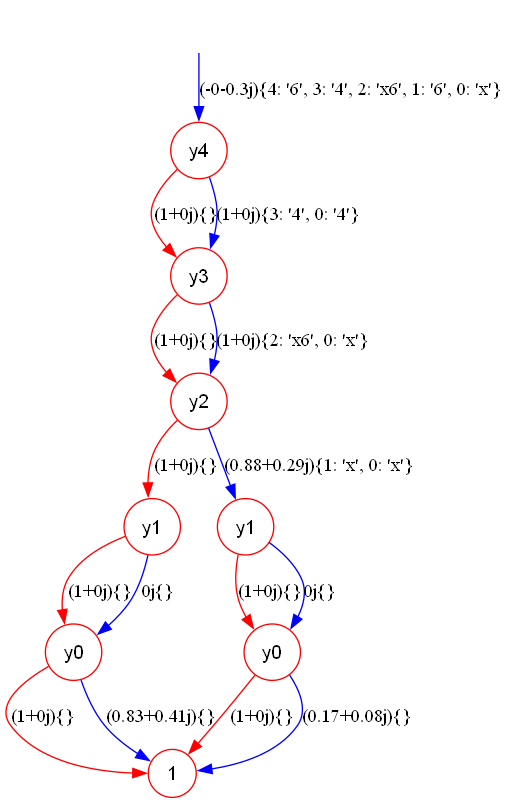

In [10]:
n=5
m=100

cir=gen_cir('Random_Clifford_T',n,m)

# cir = QuantumCircuit.from_qasm_file('18_2.qasm')
tdd=simulate(cir,True,n)
# print(tdd.key_2_index)
# tdd=renormalize(tdd)
tdd.show()

C:\Users\23626\AppData\Local\Temp\ipykernel_21536\2425442481.py:176: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir_end_t0.data:
C:\Users\23626\AppData\Local\Temp\ipykernel_21536\2425442481.py:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir.data:


1
2
3
True


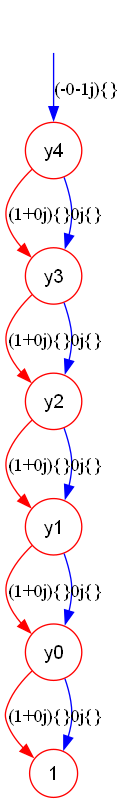

In [11]:
cir_head = QuantumCircuit(n)
# tdd222=tdd.self_copy()
cir_end,_ = state_pre(tdd.self_copy())
print(1)
tdd_new2 = update_tdd(tdd,cir_head,cir_end)
print(2)
tdd_new2 = renormalize(tdd_new2)
print(3)
print(is_successful(tdd_new2,n))
tdd_new2.show()

In [12]:
n=10
m=100
g_num = 0
g_num2=0
g_num3=0
r = 20
tt = 0
for k in range(r):
    # if k%10==0:
    print(k)
    k+=1
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,True,n)
    print('node:',tdd2.node_number())
    cir_head = QuantumCircuit(n)
    t_start=time.time()
    cir_end,_ = state_pre(tdd2.self_copy())
    print(time.time()-t_start) #只统计态制备的时间，以及所生成电路的复杂度
    tdd_new2 = update_tdd(tdd2,cir_head,cir_end)
    tdd_new2 = renormalize(tdd_new2)
    if not is_successful(tdd_new2,n):
        print('find_one')
        break


0
node: 11
0.00865316390991211
1


C:\Users\23626\AppData\Local\Temp\ipykernel_21536\2425442481.py:176: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir_end_t0.data:


node: 11
0.01246786117553711
2
node: 11
0.008298635482788086
3
node: 11
0.008585691452026367
4
node: 11
0.0041713714599609375
5
node: 11
0.00835728645324707
6
node: 11
0.008222818374633789
7
node: 11
0.00807499885559082
8
node: 11
0.008409738540649414
9
node: 16


C:\Users\23626\AppData\Local\Temp\ipykernel_21536\2425442481.py:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for g, qargs, cargs in cir.data:


0.3164496421813965
10
node: 11
0.008323907852172852
11
node: 11
0.009590625762939453
12
node: 12
0.15477252006530762
13
node: 11
0.00800633430480957
14
node: 11
0.008349180221557617
15
node: 11
0.00830221176147461
16
node: 11
0.007980108261108398
17
node: 11
0.0
18
node: 14
0.20455670356750488
19
node: 11
0.006980180740356445
